## Test For Stationarity

Using various unit root tests from our Quarter 1 project.

It is important to ensure that all variables have the same order of integration, as is required by the VAR model. We simplify this by requiring all our data to be stationary, applying first-order differencing as needed.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from arch.unitroot import ADF, KPSS, DFGLS, PhillipsPerron


from data import grab_dataset

### Functions to Run Stationarity Tests

In [2]:
#Helper function to get test decisions
def decision(x):
    if x < .05:
        return 'Reject'
    return 'Fail to Reject'

# Helper function to get stationary I(0) or non-stationary I(1)
def is_stationary(decision, null_h):
    res = {
        'Reject': {
            'The process is weakly stationary.': 'I(1)',
            'The process contains a unit root.': 'I(0)'
        },
        'Fail to Reject': {
            'The process is weakly stationary.': 'I(0)',
            'The process contains a unit root.': 'I(1)'
        }
    }

    return res[decision][null_h]

#Helper function to run a test with a given dataframe, trend, and name. Appends to stationarity_gt
def run_test(stationarity, data, test, trend, name, max_lag=None):
    '''
    Run a given stationarity test, and place the result into a row of the given `stationarity`
    dataframe.

    :stationarity (pd.DataFrame): DataFrame to store results in. This function assumes that it has rows 
        ['sample', 'method', 'trend', 't_stat', 'p_val', 'decision']
    :data (list-like): Data to test for stationarity
    :test (a test from arch.unitroot): Class of the test to run
    :trend (str): one of 'n', 'c', 'ct', for "no trend", "constant trend" or "constant and linear time trend"
    :name (str): Name of the test
    :max_lag (positive int): maximum number of lags to consider, using BIC to select lags where applicable

    :return: None
    
    '''
    #Has to try bc KPSS and DFGLS has no 'None' trend
    try:
        if test in ['ADF', 'DFGLS']:
            results = test(data, max_lags=max_lag, trend=trend, method='BIC')
        else:
            results = test(data, lags=None, trend=trend)
        # print(name, test.__name__, trend, results.stat, results.pvalue, is_stationary(decision(results.pvalue), results.null_hypothesis))
        stationarity.loc[len(stationarity.index)] = [name,
                                                           test.__name__,
                                                            trend,
                                                            results.stat,
                                                            results.pvalue,
                                                            is_stationary(decision(results.pvalue), results.null_hypothesis)
                                                          ]
    #Appends null values where trends cannot apply to function
    except ValueError:
        stationarity.loc[len(stationarity.index)] = [name,
                                                            test.__name__,
                                                            trend,
                                                            np.nan,
                                                            np.nan,
                                                            np.nan
                                                            ]

In [3]:
def run_all_tests(var, var_name, tests, trend_names):
    '''
    Run all given tests with all given trend names for a given time series.

    :var (list-like): Data to test for stationarity
    :var_name (str): Name of the data
    :tests (list-like of arch.unitroot tests): Classes of tests to perform
    :trend_names (list-like of str): May only contain 'n', 'c', or 'ct'

    :return: pd.DataFrame of test results
    '''
    #Create dataframe to store test results
    stationarity = pd.DataFrame(columns = ['sample', 'method', 'trend', 't_stat', 'p_val', 'decision'])
    for test in tests:
        for trend in trend_names:
            max_lags = 50
            run_test(stationarity, var, test, trend, var_name, max_lags)

    return stationarity

### Global temperature (monthly)

,year,month,temp_change
0,1880,Jan,-0.19
1,1881,Jan,-0.20
2,1882,Jan,0.16
3,1883,Jan,-0.29
4,1884,Jan,-0.13


<AxesSubplot:>

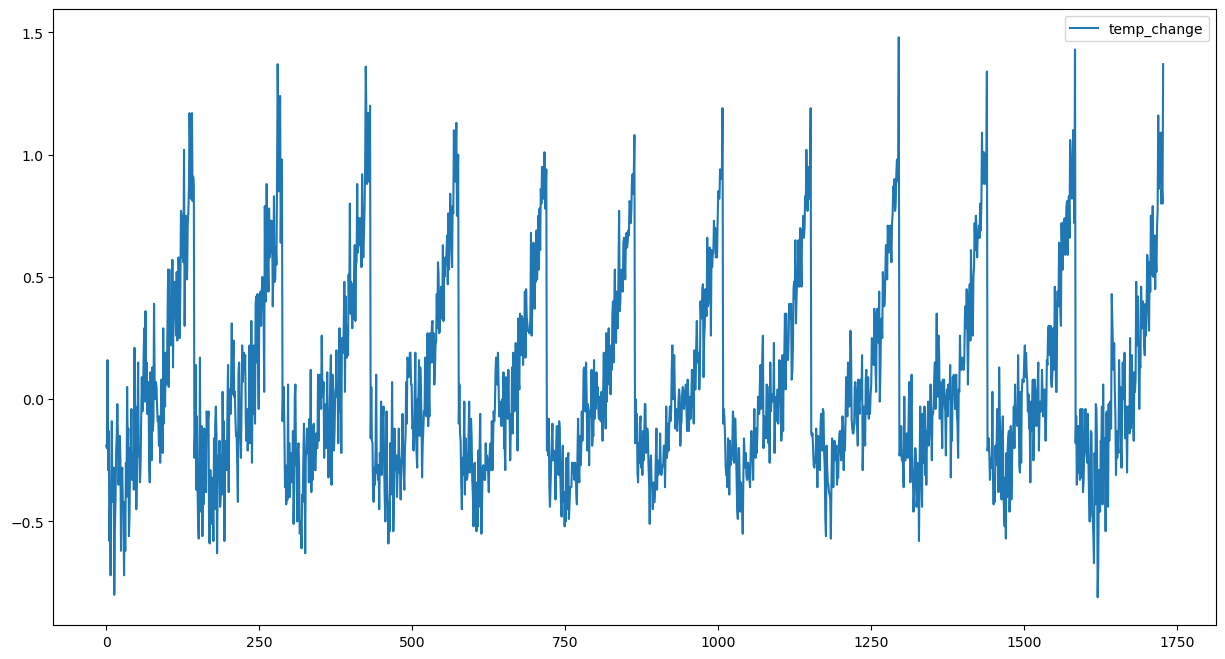

In [4]:
temp_monthly = grab_dataset('global_temp', 'monthly')
display(temp_monthly.head())
temp_monthly.plot(y='temp_change', figsize = (15,8))

In [5]:
var_name = 'temp_monthly'
var = temp_monthly['temp_change']

tests = [KPSS, ADF, PhillipsPerron, DFGLS]
trend_names = ['n', 'c', 'ct']

run_all_tests(var, var_name, tests, trend_names)

,sample,method,trend,t_stat,p_val,decision
0,temp_monthly,KPSS,n,NaN,NaN,NaN
1,temp_monthly,KPSS,c,0.067049,7.707825e-01,I(0)
2,temp_monthly,KPSS,ct,0.020808,9.713692e-01,I(0)
3,temp_monthly,ADF,n,-5.885933,1.643591e-08,I(0)
4,temp_monthly,ADF,c,-6.132756,8.325336e-08,I(0)
5,temp_monthly,ADF,ct,-6.156092,1.026066e-06,I(0)
6,temp_monthly,PhillipsPerron,n,-13.690389,7.988878e-25,I(0)
7,temp_monthly,PhillipsPerron,c,-13.983692,4.133767e-26,I(0)
8,temp_monthly,PhillipsPerron,ct,-14.063663,9.632855e-22,I(0)
9,temp_monthly,DFGLS,n,NaN,NaN,NaN


### Stationarity Test Results For Global Temperature

Since the global temperature is measured in *change* in global temperature, so we see that it is already strongly stationary with order of intergration 0.

# Electricity Generation (monthly)

,year,month,elec_generation
0,1973,Jan,160.218
1,1973,Feb,143.539
2,1973,Mar,148.158
3,1973,Apr,139.589
4,1973,May,147.395
5,1973,Jun,161.244
6,1973,Jul,173.733
7,1973,Aug,177.365
8,1973,Sep,156.875
9,1973,Oct,154.197


<AxesSubplot:>

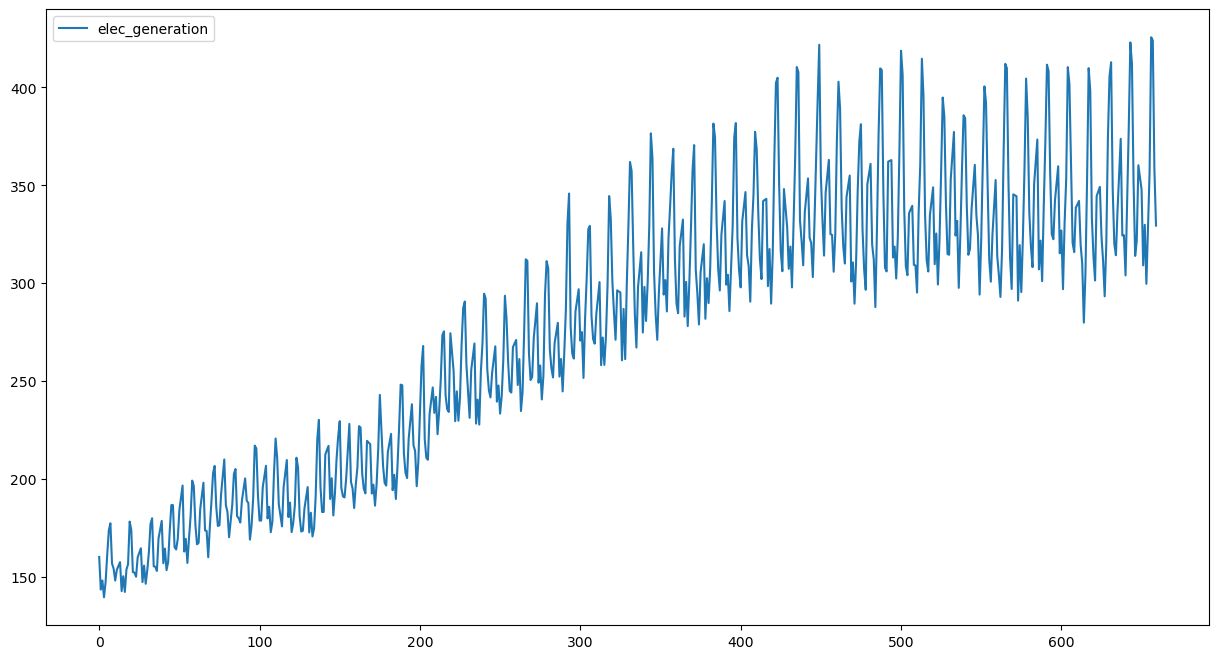

In [6]:
elec_monthly = grab_dataset('electricity', 'monthly')
display(elec_monthly.head(20))
elec_monthly.plot(y='elec_generation', figsize=(15,8))


In [7]:
var_name = 'elec_monthly'
var = elec_monthly['elec_generation']

tests = [KPSS, ADF, PhillipsPerron, DFGLS]
trend_names = ['n', 'c', 'ct']

run_all_tests(var, var_name, tests, trend_names)

,sample,method,trend,t_stat,p_val,decision
0,elec_monthly,KPSS,n,NaN,NaN,NaN
1,elec_monthly,KPSS,c,3.724664,1.000000e-04,I(1)
2,elec_monthly,KPSS,ct,1.220342,1.000000e-04,I(1)
3,elec_monthly,ADF,n,2.920240,9.997074e-01,I(1)
4,elec_monthly,ADF,c,-1.865097,3.486545e-01,I(1)
5,elec_monthly,ADF,ct,-0.759291,9.689465e-01,I(1)
6,elec_monthly,PhillipsPerron,n,0.007844,6.868831e-01,I(1)
7,elec_monthly,PhillipsPerron,c,-4.028677,1.267576e-03,I(0)
8,elec_monthly,PhillipsPerron,ct,-11.881508,5.999951e-19,I(0)
9,elec_monthly,DFGLS,n,NaN,NaN,NaN


### Stationarity Test Results For Global Electricity Generation

Electricity generation appears to be trending higher over time, so it is strongly non-stationary. 

 # Carbon Dioxide (monthly)

,year,month,co2_average
0,1979,Jan,336.56
1,1979,Feb,337.29
2,1979,Mar,337.88
3,1979,Apr,338.32
4,1979,May,338.26
5,1979,Jun,337.38
6,1979,Jul,335.56
7,1979,Aug,334.36
8,1979,Sep,335.02
9,1979,Oct,336.36


<AxesSubplot:>

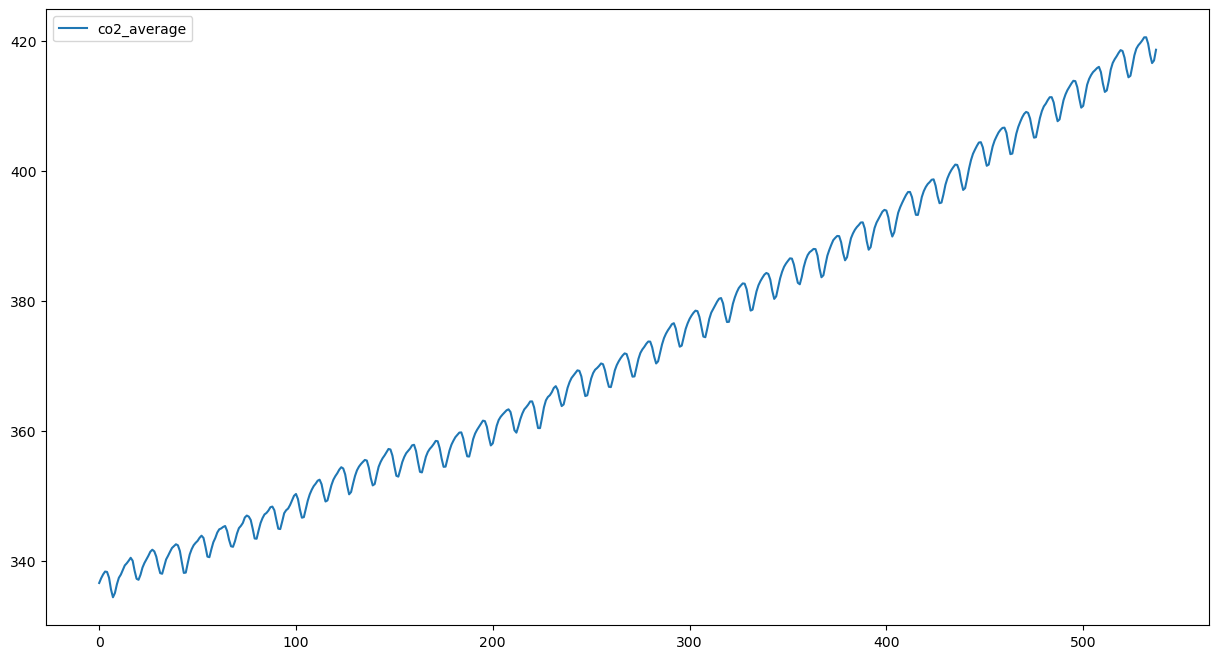

In [8]:
co2_monthly = grab_dataset('co2', 'monthly')
display(co2_monthly.head(20))
co2_monthly.plot(y='co2_average', figsize=(15,8))

In [9]:
var_name = 'co2_monthly'
var = co2_monthly['co2_average']

tests = [KPSS, ADF, PhillipsPerron, DFGLS]
trend_names = ['n', 'c', 'ct']

run_all_tests(var, var_name, tests, trend_names)

,sample,method,trend,t_stat,p_val,decision
0,co2_monthly,KPSS,n,NaN,NaN,NaN
1,co2_monthly,KPSS,c,3.430321,0.000100,I(1)
2,co2_monthly,KPSS,ct,0.860579,0.000100,I(1)
3,co2_monthly,ADF,n,5.185448,1.000000,I(1)
4,co2_monthly,ADF,c,4.211349,1.000000,I(1)
5,co2_monthly,ADF,ct,-0.630434,0.977339,I(1)
6,co2_monthly,PhillipsPerron,n,5.777764,1.000000,I(1)
7,co2_monthly,PhillipsPerron,c,0.655592,0.988909,I(1)
8,co2_monthly,PhillipsPerron,ct,-3.433568,0.047062,I(0)
9,co2_monthly,DFGLS,n,NaN,NaN,NaN


### Stationarity Test Results For CO2 Emissions

CO2 emmissions have obviously been increasing over time. The graph appears to show a linear time increase, which should easily made to be stationary with a single differencing operation. Our unit root tests verify the conclusion that the CO2 data is not stationary.

# Methane (monthly)

,year,month,ch4_average
0,1983,Jul,1625.94
1,1983,Aug,1628.06
2,1983,Sep,1638.44
3,1983,Oct,1644.79
4,1983,Nov,1642.60
5,1983,Dec,1639.57
6,1984,Jan,1638.76
7,1984,Feb,1638.84
8,1984,Mar,1640.84
9,1984,Apr,1643.96


<AxesSubplot:>

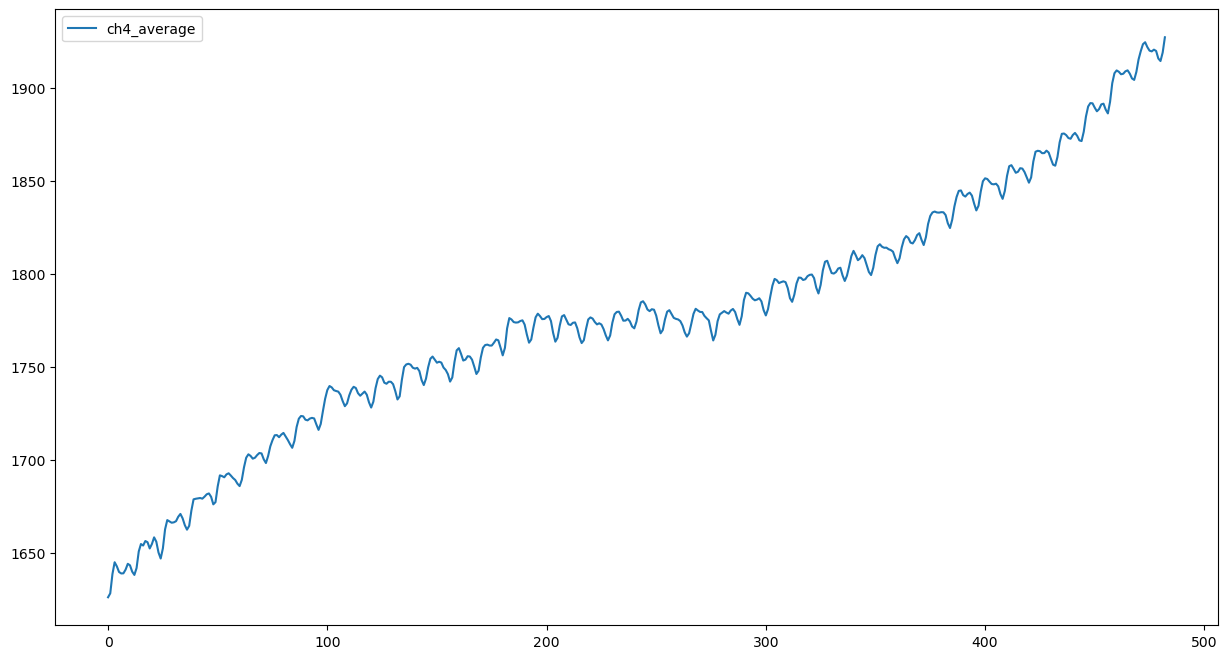

In [10]:
ch4_monthly = grab_dataset('ch4', 'monthly')
display(ch4_monthly.head(20))
ch4_monthly.plot(y='ch4_average', figsize=(15,8))


In [16]:
var_name = 'ch4_monthly'
var = ch4_monthly['ch4_average']

tests = [KPSS, ADF, PhillipsPerron, DFGLS]
trend_names = ['n', 'c', 'ct']

run_all_tests(var, var_name, tests, trend_names)

,sample,method,trend,t_stat,p_val,decision
0,ch4_monthly,KPSS,n,NaN,NaN,NaN
1,ch4_monthly,KPSS,c,3.508818,0.000100,I(1)
2,ch4_monthly,KPSS,ct,0.444719,0.000100,I(1)
3,ch4_monthly,ADF,n,2.762377,0.999375,I(1)
4,ch4_monthly,ADF,c,0.879852,0.992822,I(1)
5,ch4_monthly,ADF,ct,-0.635924,0.977035,I(1)
6,ch4_monthly,PhillipsPerron,n,5.490000,1.000000,I(1)
7,ch4_monthly,PhillipsPerron,c,-0.445305,0.902255,I(1)
8,ch4_monthly,PhillipsPerron,ct,-1.996434,0.603375,I(1)
9,ch4_monthly,DFGLS,n,NaN,NaN,NaN


### Stationarity Test Results For Methane Emissions

CH4 emissions are also increasing over time, although not in a clearly linear fashion like CO2. Nevertheless, performing a first-order differencing should be enough to make it stationary.